### In this Notebook i iterate over the models options to get a baseline

In [1]:
import tensorflow
from keras import Sequential, Input,layers,models
import numpy as np
import pandas as pd
import librosa

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

2025-12-09 14:19:03.389916: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-09 14:19:04.196312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 14:19:07.374672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
from pathlib import Path
import sys, os

# Find the repo root by walking up until we find 'utils'
repo_root = Path.cwd()
while not (repo_root / "utils").exists():
    if repo_root.parent == repo_root:
        raise RuntimeError("Cannot find repo root containing 'utils' from cwd: " + str(Path.cwd()))
    repo_root = repo_root.parent

# Prepend repo_root so `from utils...` works
sys.path.insert(0, str(repo_root))
print("Added to sys.path:", repo_root)

# Now import
from utils.create_table import create_table

Added to sys.path: /home/edgar/code/Arkyed/08-Project/databass-code/DataBass


In [3]:
### using model/dense.py fonctions and utils create_table_from_csv we're gonne to create X and y our features and target

audio_files_paths = '/home/edgar/code/Arkyed/08-Project/databass-code/DataBass/raw_data/IDMT-SMT-AUDIO-EFFECTS/IDMT-SMT-AUDIO-EFFECTS/IDMT-SMT-AUDIO-EFFECTS/Bass monophon2/Bass monophon2/Samples/Overdrive'

create_table()
table = pd.read_csv('table_correspondance_notes_basse.csv')

Table créée


In [4]:
table

,corde,case,note,fréquence (Hz)
0,E,0,E1,41.20
1,E,1,F1,43.65
2,E,2,F♯1,46.25
3,E,3,G1,49.00
4,E,4,G♯1,51.91
...,...,...,...,...
95,G,20,D♯4,311.13
96,G,21,E4,329.63
97,G,22,F4,349.23
98,G,23,F♯4,370.00


In [5]:
from extract.chorus_bass_extract import extract_chorus_bass_list

In [6]:
WORKING_DIR = os.environ.get('WORKING_DIR')
extract_chorus_bass_list(WORKING_DIR)

Loading chorus bass data from /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/raw_data/Bass monophon/Lists/Chorus...
                 fileID instrument instrumentsetting playstyle midinr string  \
0  B33-28100-3311-00989          B                 3         3     28      1   
1  B33-29101-3311-00990          B                 3         3     29      1   
2  B33-30102-3311-00991          B                 3         3     30      1   
3  B33-31103-3311-00992          B                 3         3     31      1   
4  B33-32104-3311-00993          B                 3         3     32      1   

  fret fxgroup fxtype fxsetting filenr note_name  \
0   00       3     31         1  00989        E1   
1   01       3     31         1  00990        F1   
2   02       3     31         1  00991       F#1   
3   03       3     31         1  00992        G1   
4   04       3     31         1  00993       G#1   

                                           file_path  
0  Bass monophon/Samples

In [7]:
chorus_bass_list = pd.read_csv(f'{WORKING_DIR}/data/preprocessed/chorus_bass_list.csv')
chorus_bass_list.sample()

,fileID,instrument,instrumentsetting,playstyle,midinr,string,fret,fxgroup,fxtype,fxsetting,filenr,note_name,file_path
1379,B53-39301-3313-02472,B,5,3,39,3,1,3,31,3,2472,D#2,Bass monophon/Samples/Chorus/B53-39301-3313-02...


In [117]:
chorus_bass_list['file_path'][0]

'Bass monophon/Samples/Chorus/B33-28100-3311-00989.wav'

In [8]:
len(chorus_bass_list['note_name'].unique())

28

In [9]:
wave, sr = librosa.load(WORKING_DIR + '/raw_data/' + chorus_bass_list['file_path'][0])

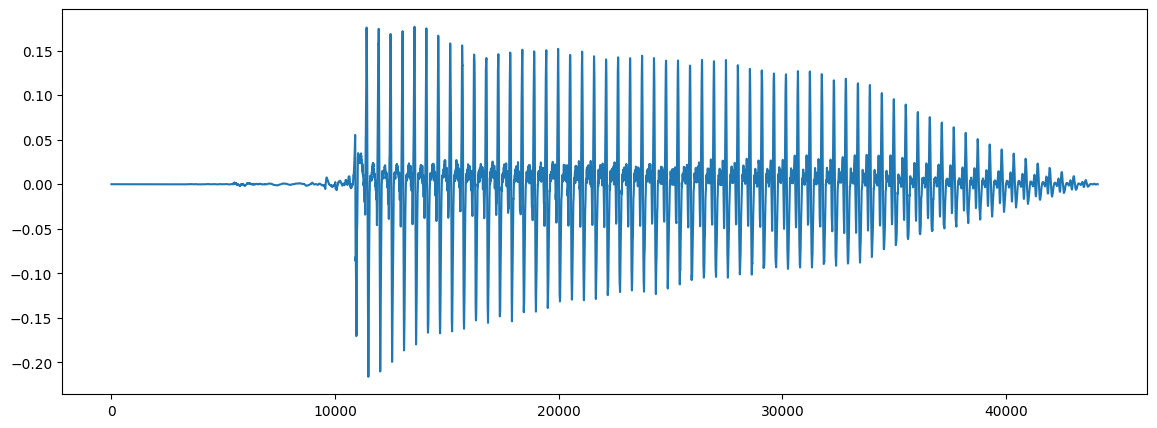

In [10]:
#plot the wave
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(wave)

In [ ]:
length_before = 1000
length_after = 5000

In [68]:
def select_starting_point(y, length_before=1000, length_after=5000):
    start_ind = 0
    for i in range(len(y)):
        if y[i] >= 0.9 * y.max():
            start_ind = i
            break

    y_select = y[start_ind-length_before:start_ind+length_after].copy()
    return y_select


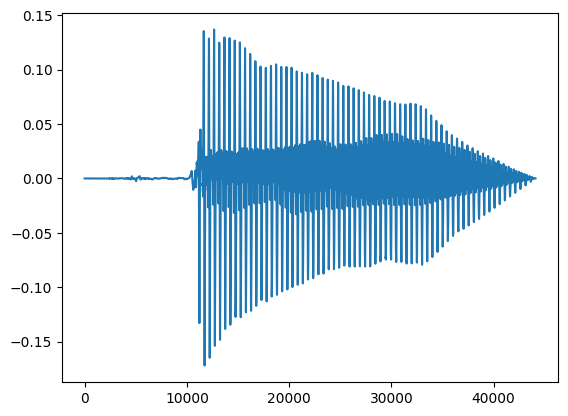

In [66]:
wave1, sr1 = librosa.load(WORKING_DIR + '/raw_data/' + chorus_bass_list['file_path'][1])
plt.plot(wave1)


array([-0.00764912, -0.00744178, -0.00722447, ..., -0.00588334,
       -0.00475456, -0.00371673], shape=(6000,), dtype=float32)

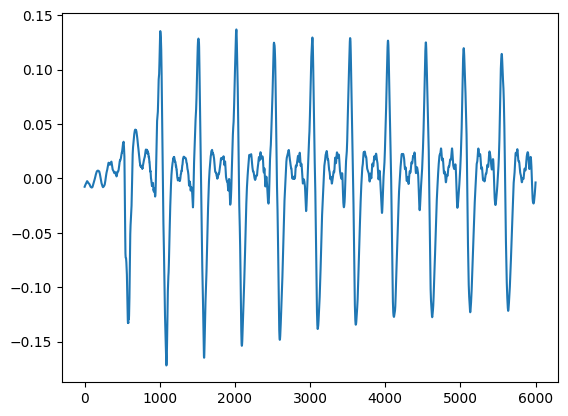

In [69]:
wave1_select = select_starting_point(wave1)
plt.plot(wave1_select)
wave1_select

In [118]:
import numpy as np
import librosa

def load_and_truncate(path, sr=22050):
    """
    Load audio file, resample, and pad/truncate to fixed length.

    Args:
        path (str): Path to audio file
        sr (int): Target sample rate (default 22050 Hz)
        max_len (int): Desired length in samples (default 5 seconds)

    Returns:
        np.ndarray: 1D array of length max_len
    """
    y, _ = librosa.load(path, sr=sr,dtype=np.float32)  # load audio
    #detect starting point of note
    y_select = select_starting_point(y)
    return y_select

In [124]:
sample_type = load_and_truncate('Sample.wav')
print(sample_type.dtype, type(sample_type))

float32 <class 'numpy.ndarray'>


In [ ]:
X = chorus_bass_list['file_path'].apply(lambda x : load_and_truncate(WORKING_DIR + '/raw_data/' + x))
y = chorus_bass_list['note_name']

In [125]:
len(X), X.shape, X.dtype, X[0].dtype, X[0].shape, type(X[0])

(1872, (1872,), dtype('O'), dtype('float32'), (6000,), numpy.ndarray)

In [126]:
print(type(X))
if hasattr(X, "dtype"):
    print(X.dtype)
else:
    print("Pas de dtype")

<class 'pandas.core.series.Series'>
object


In [127]:
X = np.stack(X).astype(np.float32)
X.shape

(1872, 6000)

In [73]:
classes = len(y.unique())
classes

28

#### encode y labels aka Notes

In [88]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(chorus_bass_list['note_name'])  # integers 0..n_classes-1
y = to_categorical(y_int)

In [89]:
categories = y.shape[1]

X shape: (1872,), X type : <class 'pandas.core.series.Series'> ,X[0].shape: (6000,), X[0] type : float32, y shape: (1872, 28)
Example X[0] length: 6000, y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


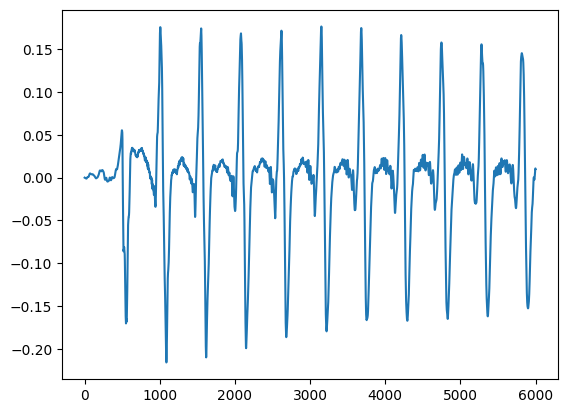

In [107]:
print(f'X shape: {X.shape}, X type : {type(X)} ,X[0].shape: {X[0].shape}, X[0] type : {X[0].dtype}, y shape: {y.shape}')
print(f'Example X[0] length: {len(X[0])}, y[0]: {y[0]}')
plt.plot(X[0])

In [ ]:
"""
Preprocess of features, not sure yet what it does.

X_features = chorus_bass_list['file_path'].apply(
    lambda x: librosa.feature.mfcc(
        y=librosa.load(WORKING_DIR + '/raw_data/' + x)[0],
        sr=librosa.load(WORKING_DIR + '/raw_data/' + x)[1],
        n_mfcc=13
    ).mean(axis=1)  # average over time → fixed-length vector
)

X = np.vstack(X_features.values).astype(np.float32)
"""

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [19]:
unique_notes = len(table.note.unique())
unique_notes

40

In [129]:
print(len(X[0]),len(y[0]),X[0].shape)
print(len(X_train[0]), len(y_train[0]) , X[0].shape)

6000 28 (6000,)
6000 28 (6000,)


In [130]:
input_shape = (X[0].shape[0],1)
input_shape

(6000, 1)

In [131]:
## create dense model and compile dense model :
def make_model(input_shape):
    input_layer = layers.Input(shape=input_shape)

    conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    gap = layers.GlobalAveragePooling1D()(conv3)

    output_layer = layers.Dense(categories, activation="softmax")(gap)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape)

In [100]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 6000, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 6000, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 6000, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 6000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,548 (107.61 KB)

 Trainable params: 27,164 (106.11 KB)

 Non-trainable params: 384 (1.50 KB)

In [136]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [134]:
print(type(X_train))
print(X_train.dtype if hasattr(X_train, "dtype") else "no dtype")
print(type(y_train))
print(y_train.dtype if hasattr(y_train, "dtype") else "no dtype")

<class 'numpy.ndarray'>
float32
<class 'numpy.ndarray'>
float64


In [137]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 773ms/step - accuracy: 0.0630 - loss: 3.3321 - val_accuracy: 0.0725 - val_loss: 3.3105
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 681ms/step - accuracy: 0.0668 - loss: 3.2395 - val_accuracy: 0.0382 - val_loss: 3.2873
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 754ms/step - accuracy: 0.0706 - loss: 3.2180 - val_accuracy: 0.0382 - val_loss: 3.2768
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 763ms/step - accuracy: 0.0620 - loss: 3.2119 - val_accuracy: 0.0382 - val_loss: 3.2780
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 716ms/step - accuracy: 0.0725 - loss: 3.2111 - val_accuracy: 0.0382 - val_loss: 3.2751
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 750ms/step - accuracy: 0.0735 - loss: 3.2115 - val_accuracy: 0.0382 - val_loss: 3.2764
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 750ms/step - accuracy: 0.0697 - loss: 3.2025 - val_accuracy: 0.0382 - val_loss: 3.2715
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - accuracy: 0.0668 - loss: 3.1902 - val_accu

In [ ]:
print(f'{round(max(history.history['accuracy']),4)} is our best accuracy on training data with a Conv1D model')

0.101 is our best accuracy on training data with a Conv1D model


In [ ]:
results = model.evaluate(X_test, y_test)
print(f'{round(results[1],4)} is our accuracy on test data with a Conv1D model')

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.0605 - loss: 3.3054
0.06 is our accuracy on test data with a Conv1D model


### test with a random forest

In [155]:
from sklearn.model_selection import cross_validate

In [156]:
# create a randomforest model to try and output the note based on the audio file
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=None,random_state=42)

results = cross_validate(rf_classifier, X_train, y_train, cv=10,scoring='accuracy')
results

{'fit_time': array([12.14628768, 10.42175961, 10.15407276, 12.12986898, 10.26562452,
        10.23091006, 12.83612967, 10.11058068,  9.81855965, 11.82713151]),
 'score_time': array([0.01560426, 0.01397014, 0.01999068, 0.01440382, 0.0161047 ,
        0.01569867, 0.01784897, 0.01362586, 0.01405573, 0.01523709]),
 'test_score': array([0.83969466, 0.79389313, 0.86259542, 0.77099237, 0.76335878,
        0.82442748, 0.79389313, 0.79389313, 0.77099237, 0.83206107])}

In [ ]:
rf_classifier.fit(X_train,y_train)

In [152]:
results.score(X_test,y_test)

0.34519572953736655

In [ ]:
#grid search the random forest
from sklearn.model_selection import GridSearchCV

# Définir une grille d'hyperparamètres
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [5, 10, None],
'min_samples_split': [2, 5, 10]
}

# Recherche par grille
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
